In [4]:
import sys
sys.path.append('/nfshome/hassan/QswitchNet')
from network_utils_hybrid import *
import numpy as np
import matplotlib.pyplot as plt
import os
import json


Create a network topology as a json file

This is only an example. Ideally, we want the input to be a drawing in QNDK gui which would be converted into a json file.

In [7]:
# network data

num_ToR = 4
n = 4 # must be even, starts from 4
qs_per_node = 10 # number of qubits per qpu
num_bsm_ir = 2  # number of NIR BSMs per ToR switch
num_bsm_tel = 2 # number of Tel BSMs per Telecom aggregate switch

telecom_gen_rate = 1/(1e-2) # ebit average generation time in sec
switch_duration = 1e-3 # average switching delay in sec
nir_prob = 1e-2 # NIR gen prob
qubit_reset = 1e-6 # qubit reset time in sec
comm_qs = 4

specs = {
    "buffer_size": buffer,
    "num_sw_ports": n,
    "num_ToR" : num_ToR,
    "qs_per_node" : qs_per_node,
    "bandwidth" : comm_qs,
    "num_bsm_ir" : num_bsm_ir,
    "num_bsm_tel" : num_bsm_tel,
    "telecom_gen_rate" : telecom_gen_rate,
    "switch_duration" : switch_duration,
    "num_pd" : 1, # inactive
    "num_laser" : 1, # inactive
    "num_bs" : 1, # inactive
    "num_es" : 1 # inactive
}

Input 1: Network

Read a network topology from json and convert to networkx graph

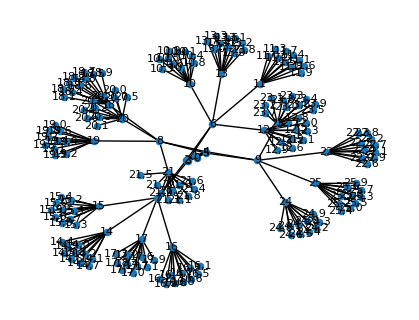

In [8]:
# generate clos topology and save it as a networkx graph

G, vertex_list = clos_hybrid(specs)
plt.figure(figsize=(4,3))
nx.draw(G, node_size=20, font_size=8, with_labels=True)


Input 2: quantum circuit 

1- Read the circuit from .py file

2- Assign logical qubits to physical qubits (Eneet's code)

In [11]:
import job1

num_qubits = 100
circuit = job1.ghz_circuit(num_qubits)
# draw circuit
# circuit.draw()

_, _, node_qubit_list = vertex_list
## trivial ordering
qubit_map = {i: node_qubit_list[i] for i in range(num_qubits)}
## random ordering
# rand_idx = sorted(range(num_qubits), key = lambda x: random.random())
# qubit_map = {i: node_qubit_list[idx] for i, idx in enumerate(rand_idx)}
print(qubit_map)


{0: '10,0', 1: '10,1', 2: '10,2', 3: '10,3', 4: '10,4', 5: '10,5', 6: '10,6', 7: '10,7', 8: '10,8', 9: '10,9', 10: '11,0', 11: '11,1', 12: '11,2', 13: '11,3', 14: '11,4', 15: '11,5', 16: '11,6', 17: '11,7', 18: '11,8', 19: '11,9', 20: '12,0', 21: '12,1', 22: '12,2', 23: '12,3', 24: '12,4', 25: '12,5', 26: '12,6', 27: '12,7', 28: '12,8', 29: '12,9', 30: '13,0', 31: '13,1', 32: '13,2', 33: '13,3', 34: '13,4', 35: '13,5', 36: '13,6', 37: '13,7', 38: '13,8', 39: '13,9', 40: '14,0', 41: '14,1', 42: '14,2', 43: '14,3', 44: '14,4', 45: '14,5', 46: '14,6', 47: '14,7', 48: '14,8', 49: '14,9', 50: '15,0', 51: '15,1', 52: '15,2', 53: '15,3', 54: '15,4', 55: '15,5', 56: '15,6', 57: '15,7', 58: '15,8', 59: '15,9', 60: '16,0', 61: '16,1', 62: '16,2', 63: '16,3', 64: '16,4', 65: '16,5', 66: '16,6', 67: '16,7', 68: '16,8', 69: '16,9', 70: '17,0', 71: '17,1', 72: '17,2', 73: '17,3', 74: '17,4', 75: '17,5', 76: '17,6', 77: '17,7', 78: '17,8', 79: '17,9', 80: '18,0', 81: '18,1', 82: '18,2', 83: '18,3', 8

Run the job scheduler with circuit and network topology as inputs

In [12]:
JSON_PATH = "../data/nir_latency.json"
with open(JSON_PATH) as f:
    time_nir = np.array(json.load(f))

switch_seq, circ_depth = eff_network_latency_dag_from_qiskit(G, qubit_map, circuit)
switch_seq = np.array(switch_seq)
print("NIR links, Telecom link:")
print(switch_seq)

tel_latency = 1/telecom_gen_rate * time_spdc(switch_seq[:,1]) 
nir_latency = qubit_reset * np.array([time_nir[k] for k in switch_seq[:,0]])
latency_combined = np.stack((tel_latency,nir_latency), axis = 1)

T_latency =  np.max(latency_combined, axis = 1).sum() + switch_duration * switch_seq.shape[0] 

print(f"Network latency: {T_latency:.4f} sec. over {len(switch_seq):d} switching events")


NIR links, Telecom link:
[[0 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 2]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 4]
 [0 2]]
Network latency: 0.3548 sec. over 31 switching events


# 